# COMP5313 Project 2: Spam Ham Email Classification (Individual)
## Student ID: 1332705
## Name: Ritik Sanjay Patel
#### Enviroment Setup(Local Conda/Anaconda Prompt):
You’ll need to create a new environment with a compatible Python version.
In Anaconda Prompt, run:

- conda create -n torchenv python=3.10 -y
- conda activate torchenv

Downloading Libraries:
- conda install pytorch torchvision torchaudio cpuonly -c pytorch -y
- verification command: python -c "import torch; print(torch.__version__); print('CUDA available:', torch.cuda.is_available())"
- conda install matplotlib numpy -y
- pip install seaborn tqdm tensorflow
- pip install scikit-learn

Downloading Dataset:
- Dataset file is already avaiable in the local floder so theres no need to download it

Adding environment to jupyter notebook:
- conda install ipykernel -y
- python -m ipykernel install --user --name=torchenv --display-name "Python (torchenv)"

When Jupyter opens in your browser, go to:
Kernel → Change kernel → Python (torchenv)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re, string
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.tree import export_graphviz

import matplotlib.pyplot as plt
import seaborn as sns

import six
from io import StringIO

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Reading And Understanding Data

In [2]:
df = pd.read_csv("spam_Emails_data.csv")

In [3]:
df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [4]:
df.shape

(193852, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [6]:
df.describe()

,label,text
count,193852,193850
unique,2,193848
top,Ham,hi
freq,102160,2


In [7]:
df.columns.tolist()

['label', 'text']

In [8]:
df.isnull().sum()

label    0
text     2
dtype: int64

So there are two rows in my data which have null valeus in text column.

# Data Cleaning And Performing EDA

In [9]:
# droping the rows with missing values
df = df.dropna(subset=["text"]).reset_index(drop=True)

In my case I have only two row which have null values. So I am dropping them.

In [10]:
# creating a user define function named clean_text 
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    s = re.sub(r'<.*?>', ' ', s)
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r'\d+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

I have created a user define function name clean_text to remove the unneccessary things from the text like urls, html tags, numbers, extra spaces and so on. I have taken this step in order to improve the quality of data.

In [11]:
# Applying cleaning
df["clean"] = df["text"].astype(str).apply(clean_text)

In [12]:
df["label"] = df["label"].map({"Spam": 1, "Ham": 0})

Here I have converted the lables into a binary representation that spam is represented using 1 and ham is represented using 0

In [13]:
df.head()

,label,text,clean
0,1,viiiiiiagraaaa\nonly for the ones that want to...,viiiiiiagraaaa only for the ones that want to ...
1,0,got ice thought look az original message ice o...,got ice thought look az original message ice o...
2,1,yo ur wom an ne eds an escapenumber in ch ma n...,yo ur wom an ne eds an escapenumber in ch ma n...
3,1,start increasing your odds of success & live s...,start increasing your odds of success live sex...
4,0,author jra date escapenumber escapenumber esca...,author jra date escapenumber escapenumber esca...


In [14]:
print("\nLabel distribution:\n", df["label"].value_counts())


Label distribution:
 label
0    102159
1     91691
Name: count, dtype: int64


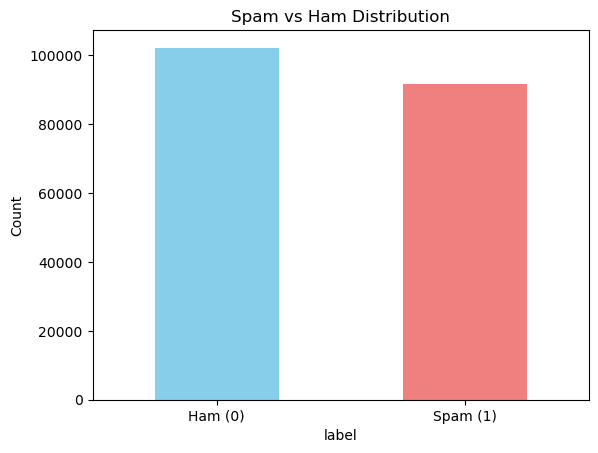

In [15]:
# Label distribution
df["label"].value_counts().plot(kind="bar", color=["skyblue", "lightcoral"])
plt.title("Spam vs Ham Distribution")
plt.xticks(ticks=[0,1], labels=["Ham (0)", "Spam (1)"], rotation=0)
plt.ylabel("Count")
plt.show()

There are around 102k ham emails and 92k sapm emails.

This shows that the dataset is fairly balanced, meaning my model won't suffer from class imbalace and it makes evaluation metrics more reliable.

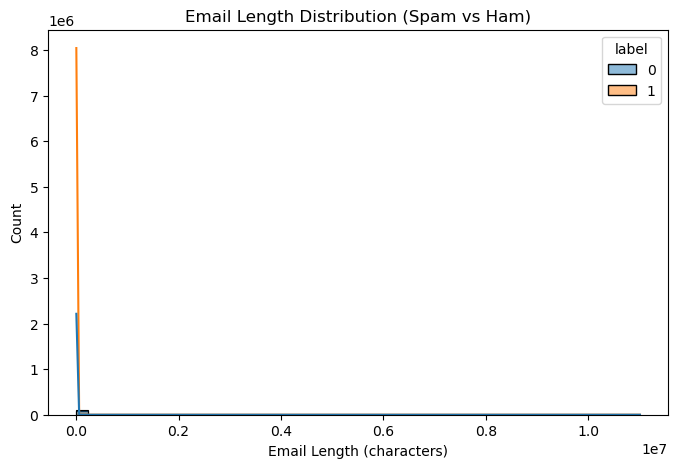

In [16]:
# Email length analysis
df["length"] = df["clean"].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="length", hue="label", bins=50, kde=True)
plt.title("Email Length Distribution (Spam vs Ham)")
plt.xlabel("Email Length (characters)")
plt.show()

From the above histogram I can see that most of the ham and spam emails have short lengths, clustered under few thousands.

However there are some extreme outlires in ham which is making x-axis streach and compress around the main region.

In [17]:
print(df.groupby("label")["length"].describe())

          count         mean           std  min    25%    50%     75%  \
label                                                                   
0      102159.0  2123.970105  35021.455871  0.0  403.0  924.0  1916.0   
1       91691.0  1391.360755   2344.810670  0.0  299.0  651.0  1536.0   

              max  
label              
0      11014078.0  
1        144036.0  


In [18]:
df = df[df["length"] < 5000].reset_index(drop=True)

Here I have handled the outliers present in the dataset as removing outlires will improve model stability and vizualization clarity.

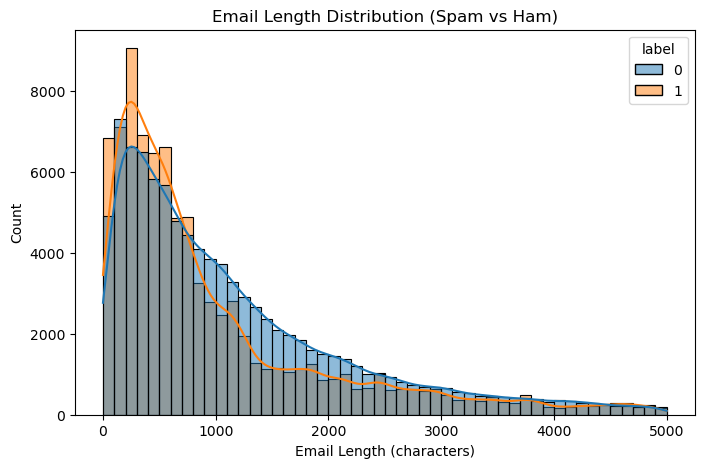

In [19]:
# Email length analysis
df["length"] = df["clean"].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="length", hue="label", bins=50, kde=True)
plt.title("Email Length Distribution (Spam vs Ham)")
plt.xlabel("Email Length (characters)")
plt.show()

Now dataset looks clean, balanced, and free from extreme outliers

In [20]:
print("\nLabel distribution:\n", df["label"].value_counts())


Label distribution:
 label
0    94960
1    86951
Name: count, dtype: int64


After cleaning and removing outliers, the dataset contains about 182k emails, almost evenly split between Ham and Spam.

# Splitting into Train and Test set

In [21]:
# splitting data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["clean"], df["label"].astype(int),
    test_size=0.2, random_state=42, stratify=df["label"]
)

I have split the data into train and test split using sklearn train_test_split. I am going to use exact same train test split for all models for fair commparision across all the models.

# TF-IDF for Logistic Regression and Desicion Tree

In [22]:
len(X_train_text), len(X_test_text)

(145528, 36383)

In [23]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf  = tfidf.transform(X_test_text)

I am going to use same TF-IDF features for logistic regression model and descicision tree model. But for Glove I will use tokenizer along with padded sequence and load pre-trained Glove into embedding layer.

# Building and Evaluating Logistic Regression Model

In [24]:
# Createing logistic regression model
lr_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

Here I have used max_iter=2000 which increases itretation to ensure convergence of large data. I have also used class_weight="balanced" to slightly adjust the weights if Ham > Spam or vice-versa

In [25]:
# Training the model
lr_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [26]:
# making predection on test data
lr_pred = lr_model.predict(X_test_tfidf)

This gives an array on 0 and 1. 0 means ham and 1 means spam

In [27]:
def report_results(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    print(f"{name} -> Accuracy: {acc:.4f} | Precision: {pr:.4f} | Recall: {rc:.4f} | F1-Score: {f1:.4f}\n")
    print(classification_report(y_true, y_pred, target_names=["Ham (0)", "Spam (1)"]))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Here I have created a user define function report_resluts to get Accuraccy, Presicion, recall, F1-Score and confusion matrix. I have created a user define function so that I can reuse it for all the models.

Logistic Regression (TF-IDF) -> Accuracy: 0.9799 | Precision: 0.9724 | Recall: 0.9859 | F1-Score: 0.9791

              precision    recall  f1-score   support

     Ham (0)       0.99      0.97      0.98     18992
    Spam (1)       0.97      0.99      0.98     17391

    accuracy                           0.98     36383
   macro avg       0.98      0.98      0.98     36383
weighted avg       0.98      0.98      0.98     36383



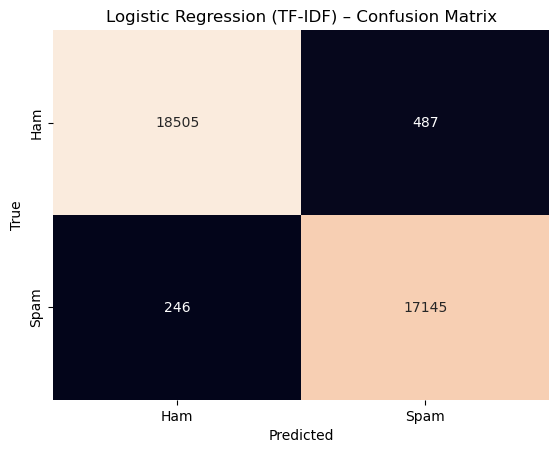

In [28]:
# Evaluating the Performance of the model
report_results("Logistic Regression (TF-IDF)", y_test, lr_pred)

#### Interpretation of the Model Performance
- Accuracy: The overall accuracy is around 97.99%. This implies that the logistics regressions desicision boundary between spam and ham is very well learned from the TF-IDF features.
- Precision: When the models predicts spam its correct 97.24% of times. This is important in email filtering as users hate losing legitimate emails to the spam folder.
- Recall: The model catches 98.59 % of all actual spam mails. This makes the filter highly reliable in catching almost all spam messages.
- F1-Score: 97.91%

#### Conclusion for Logistic Regression

The Logistic Regression model with TF-IDF features provides highly accurate, balanced, and reliable email classification.
It correctly identifies spam while maintaining very low false positive and false negative rates.

# Building and Evaluating Desicision Tree Classifire Model

In [29]:
# Creating Decision Tree model
dt_model = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    max_depth=40,
    min_samples_leaf=2
)

- Here I have used class_weight="balanced" to prevent slight imbalance
- I have set max_depth to 40 to prevent overfitting
- I have also set min_samples_leaf=2 to ensure that each leaf has atlest 2 samples

In [30]:
# training the model
dt_model.fit(X_train_tfidf, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,40
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [31]:
# making desicisions on test data
dt_pred = dt_model.predict(X_test_tfidf)

Decision Tree (TF-IDF) -> Accuracy: 0.9463 | Precision: 0.9174 | Recall: 0.9754 | F1-Score: 0.9455

              precision    recall  f1-score   support

     Ham (0)       0.98      0.92      0.95     18992
    Spam (1)       0.92      0.98      0.95     17391

    accuracy                           0.95     36383
   macro avg       0.95      0.95      0.95     36383
weighted avg       0.95      0.95      0.95     36383



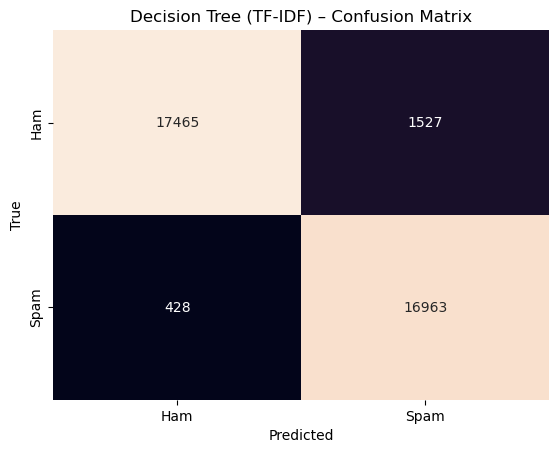

In [32]:
# Evaluating the performance of the model
report_results("Decision Tree (TF-IDF)", y_test, dt_pred)

#### Interpretation of the Model Performance
- Accuracy: The overall accuracy is around 94.63%. This is slightly lower than Logistic Regression (97.99%), which is expected as trees can overfit TF-IDF data.
- Precision: When the models predicts spam its correct 91.74% of times. This implies that the tree makes more false spam predictions
- Recall: The model catches 97.54 % of all actual spam mails. This makes the filter highly reliable in catching almost all spam messages.
- F1-Score: 94.55%

#### Conclusion for desicsion tree model
The Decision Tree model demonstrates strong spam detection capability with 94.6% accuracy and high recall.

# Building and Evaluating Glove Model 

In [33]:
# Tokenizing and Padding
MAX_VOCAB = 50000     # cap vocabulary size
MAX_LEN   = 200       # sequence length 

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(X_train_text)

X_train_seq = tok.texts_to_sequences(X_train_text)
X_test_seq  = tok.texts_to_sequences(X_test_text)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")

y_train_dl = y_train.values if hasattr(y_train, "values") else y_train
y_test_dl  = y_test.values  if hasattr(y_test, "values")  else y_test

len(tok.word_index), X_train_pad.shape, X_test_pad.shape

(359955, (145528, 200), (36383, 200))

In [34]:
# Loading Glove and building the embedding matrix
EMB_DIM = 100
GLOVE_PATH = "glove.6B.100d.txt"

emb_index = {}
with open(GLOVE_PATH, encoding="utf8") as f:
    for line in f:
        values = line.rstrip().split(" ")
        word = values[0]
        vec  = np.asarray(values[1:], dtype="float32")
        emb_index[word] = vec

word_index = tok.word_index
vocab_size = min(MAX_VOCAB, len(word_index) + 1)

emb_matrix = np.random.normal(scale=0.6, size=(vocab_size, EMB_DIM)).astype(np.float32)
for w, i in word_index.items():
    if i < vocab_size and w in emb_index:
        emb_matrix[i] = emb_index[w]

vocab_size

50000

In [35]:
# Defining the model (Embedding + LSTM)
model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMB_DIM,
        weights=[emb_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1, activation="sigmoid"),
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

C:\Users\ritik\anaconda3\envs\torchenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,000,000 (19.07 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,000,000 (19.07 MB)

In [36]:
# Training with early stopping 
es = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_dl,
    validation_split=0.1,
    epochs=6,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

Epoch 1/6
512/512 ━━━━━━━━━━━━━━━━━━━━ 132s 254ms/step - accuracy: 0.6868 - loss: 0.5911 - val_accuracy: 0.8152 - val_loss: 0.4658
Epoch 2/6
512/512 ━━━━━━━━━━━━━━━━━━━━ 124s 242ms/step - accuracy: 0.7816 - loss: 0.4841 - val_accuracy: 0.8521 - val_loss: 0.4023
Epoch 3/6
512/512 ━━━━━━━━━━━━━━━━━━━━ 124s 242ms/step - accuracy: 0.8435 - loss: 0.3925 - val_accuracy: 0.8511 - val_loss: 0.4205
Epoch 4/6
512/512 ━━━━━━━━━━━━━━━━━━━━ 127s 247ms/step - accuracy: 0.8680 - loss: 0.3388 - val_accuracy: 0.9156 - val_loss: 0.2335
Epoch 5/6
512/512 ━━━━━━━━━━━━━━━━━━━━ 136s 266ms/step - accuracy: 0.8946 - loss: 0.2779 - val_accuracy: 0.9282 - val_loss: 0.1972
Epoch 6/6
512/512 ━━━━━━━━━━━━━━━━━━━━ 144s 280ms/step - accuracy: 0.9094 - loss: 0.2425 - val_accuracy: 0.9373 - val_loss: 0.1732


1137/1137 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step
Deep Learning (GloVe + LSTM) -> Accuracy: 0.9380 | Precision: 0.9292 | Recall: 0.9420 | F1-Score: 0.9356

              precision    recall  f1-score   support

     Ham (0)       0.95      0.93      0.94     18992
    Spam (1)       0.93      0.94      0.94     17391

    accuracy                           0.94     36383
   macro avg       0.94      0.94      0.94     36383
weighted avg       0.94      0.94      0.94     36383



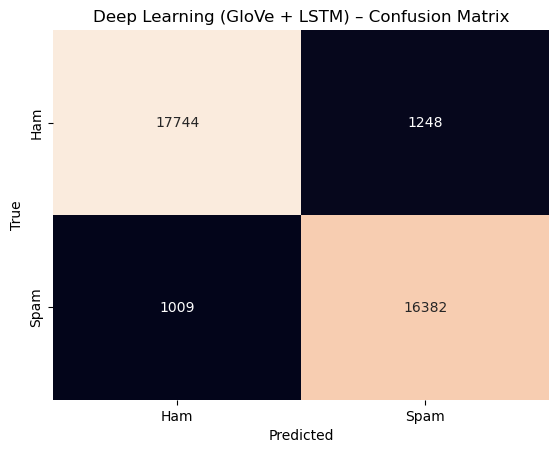

In [37]:
# Evaluating the performance of the model
dl_probs = model.predict(X_test_pad).ravel()
dl_pred  = (dl_probs >= 0.5).astype(int)

report_results("Deep Learning (GloVe + LSTM)", y_test_dl, dl_pred)

#### Interpretation of the Model Performance
- Accuracy: The overall accuracy is around 93.80%. This is similar to Logistic Regression (97.99%) and Desicision Tree (94.6).
- Precision: When the models predicts spam its correct 92.92% of times.
- Recall: The model catches 94.2 % of all actual spam mails. This makes the filter highly reliable in catching almost all spam messages.
- F1-Score: 93.56%

# Comparing Logistic Regression, Desicision Tree and Glove Model

In [38]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def row(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    return {"Model": name, "Accuracy": acc, "Precision": pr, "Recall": rc, "F1": f1}

rows = []
rows.append(row("Logistic Regression (TF-IDF)", y_test, lr_pred))
rows.append(row("Decision Tree (TF-IDF)", y_test, dt_pred))
rows.append(row("DL (GloVe + LSTM)", y_test_dl, dl_pred))

pd.DataFrame(rows).sort_values("F1", ascending=False)


,Model,Accuracy,Precision,Recall,F1
0,Logistic Regression (TF-IDF),0.979853,0.972380,0.985855,0.979071
1,Decision Tree (TF-IDF),0.946266,0.917415,0.975390,0.945514
2,DL (GloVe + LSTM),0.937966,0.929212,0.941981,0.935553


The results show that the Logistic Regression model achieved the highest performance, with an accuracy of 97.98% and an F1-score of 97.9%. The Decision Tree followed with 94.6% accuracy, while the Deep Learning (GloVe + LSTM) model reached 93.8% accuracy. These results indicate that for structured, keyword-based datasets such as spam detection, traditional models like Logistic Regression often outperform more complex neural architectures.